In [5]:
import dowhy
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot
import pandas as pd
import numpy as np
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()
# split data into X and y

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [7]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

In [8]:
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries


hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
reservation_stat

In [9]:
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

In [10]:
dataset.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status                0
reservation_status_date           0
total_stay                        0
guests                            4
different_room_assigned           0
dtype: int64

In [11]:
dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)


In [12]:
dataset_copy = dataset

In [13]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot
# split data into X and y
X = dataset_copy
y = dataset_copy['is_canceled']
X = X.drop(['is_canceled'],axis=1)
# One-Hot Encode the dataset
X = pd.get_dummies(X)
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, predictions))

/home/dc/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 86.40%
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     14997
           1       0.83      0.80      0.81      8881

    accuracy                           0.86     23878
   macro avg       0.86      0.85      0.85     23878
weighted avg       0.86      0.86      0.86     23878



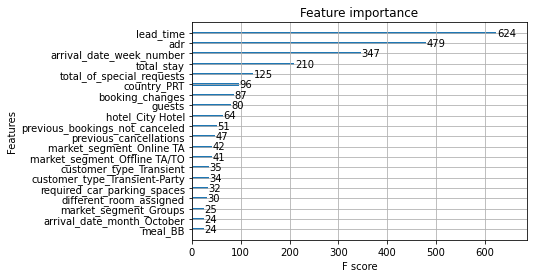

In [14]:
# plot feature importance
plot_importance(model,max_num_features=20)
pyplot.show()

In [15]:
dataset_copy.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')

In [18]:
import pygraphviz
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders"];
is_repeated_guest;
total_stay;
guests;
meal;
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
U -> different_room_assigned; U -> lead_time; U -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->is_canceled;
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> is_canceled;
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
}"""


INFO:dowhy.causal_model:Model to find the causal effect of treatment ['different_room_assigned'] on outcome ['is_canceled']


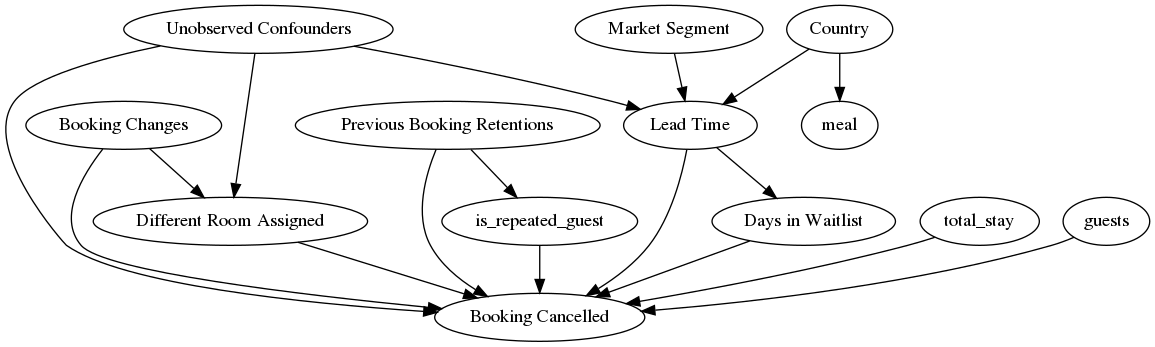

In [19]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='different_room_assigned',
        outcome='is_canceled')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))